# Modeling and Simulation in Python

Chapter 2: Simulation

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


We'll start with the same code we saw last time: the magic command that tells Jupyter where to put the figures, and the import statement that gets the functions defined in the `modsim` module.

In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

%matplotlib inline

from modsim import *

## More than one System object

Here's the code from the previous chapter, with two changes:

1. I've added DocStrings that explain what each function does, and what parameters it takes.

2. I've added a parameter named `system` to the functions so they work with whatever `System` object we give them, instead of always using `bikeshare`.  That will be useful soon when we have more than one `System` object.

In [2]:
def run_steps(system, num_steps=1, p1=0.5, p2=0.5):
    """Simulate the given number of time steps.
    
    system: bikeshare System object
    num_steps: number of time steps
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    for i in range(num_steps):
        step(system, p1, p2)
        plot_system(system)
        
def step(system, p1=0.5, p2=0.5):
    """Simulate one minute of time.
    
    system: bikeshare System object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    if flip(p1):
        bike_to_wellesley(system)
    
    if flip(p2):
        bike_to_olin(system)
        
def bike_to_wellesley(system):
    """Move one bike from Olin to Wellesley.
    
    system: bikeshare System object
    """
    move_bike(system, 1)
    
def bike_to_olin(system):
    """Move one bike from Wellesley to Olin.
    
    system: bikeshare System object
    """
    move_bike(system, -1)
    
def move_bike(system, n):
    """Move a bike.
    
    system: bikeshare System object
    n: +1 to move from Olin to Wellesley or
       -1 to move from Wellesley to Olin
    """
    system.olin -= n
    system.wellesley += n
    
def plot_system(system):
    """Plot the current system of the bikeshare system.
    
    system: bikeshare System object
    """
    plot(system.olin, 'rs-', label='Olin')
    plot(system.wellesley, 'bo-', label='Wellesley')
    
def decorate():
    """Add a legend and label the axes.
    """
    legend(loc='best')
    label_axes(title='Olin-Wellesley Bikeshare',
               xlabel='Time step (min)', 
               ylabel='Number of bikes')

Now we can create more than one `System` object:

In [3]:
bikeshare1 = System(olin=10, wellesley=2)
bikeshare1

,value
olin,10
wellesley,2


In [4]:
bikeshare2 = System(olin=10, wellesley=2)
bikeshare2

,value
olin,10
wellesley,2


And whenever we call a function, we indicate which `System` object to work with:

In [5]:
bike_to_olin(bikeshare1)

In [6]:
bike_to_wellesley(bikeshare2)

And you can confirm that the different systems are getting updated independently:

In [7]:
bikeshare1

,value
olin,11
wellesley,1


In [8]:
bikeshare2

,value
olin,9
wellesley,3


## Negative bikes

In the code we have so far, the number of bikes at one of the locations can go negative, and the number of bikes at the other location can exceed the actual number of bikes in the system.

If you run this simulation a few times, it happens quite often.

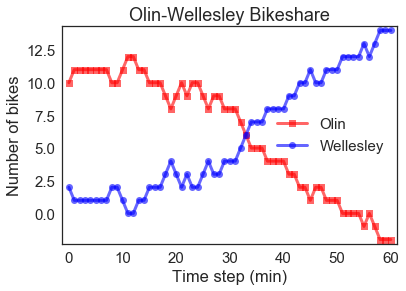

In [9]:
bikeshare = System(olin=10, wellesley=2)
newfig()
plot_system(bikeshare)
decorate()
run_steps(bikeshare, 60, 0.4, 0.2)

But this is relatively easy to fix, using the `return` statement to exit the function early if the update would cause negative bikes.

If the second `if` statement seems confusing, remember that `n` can be negative.

In [10]:
def move_bike(system, n):
    # make sure the number of bikes won't go negative
    olin_temp = system.olin - n
    if olin_temp < 0:
        #print('sorry, no bikes left')
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        #print('sorry, no bikes left')
        return
    
    # update the system
    system.olin = olin_temp
    system.wellesley = wellesley_temp

Now if you run the simulation again, it should behave.

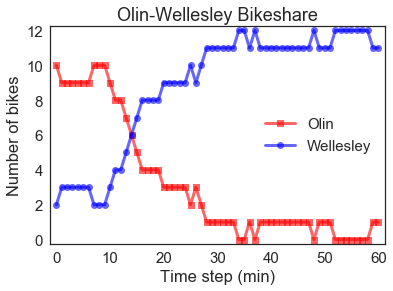

In [11]:
bikeshare = System(olin=10, wellesley=2)
newfig()
plot_system(bikeshare)
decorate()
run_steps(bikeshare, 60, 0.4, 0.2)

The variables `olin` and `wellesley` are created inside `move_bike`, so they are local.  When the function ends, they go away.

If you try to access a local variable from outside its function, you get an error:

In [12]:
# If you remove the # from the last line in this cell and run it, you'll get
# NameError: name 'olin' is not defined

#olin

**Exercise:** Add print statements in `move_bike` so it prints a message each time a customer arrives and doesn't find a bike.  Run the simulation again to confirm that it works as you expect.  Then you might want to remove the print statements before you go on.

## Comparison operators

The `if` statements in the previous section used the comparison operator `<`.  The other comparison operators are listed in the book.

It is easy to confuse the comparison operator `==` with the assignment operator `=`.

Remember that `=` creates a variable or gives an existing variable a new value.

In [13]:
x = 4

Whereas `==` compared two values and returns `True` if they are equal.

In [14]:
x == 5

False

You can use `==` in an `if` statement.

In [15]:
if x > 5:
    print('yes, x is greater than 5')
else:
    print('no, x is less than 5')

no, x is less than 5


But if you use `=` in an `if` statement, you get an error.

In [16]:
# If you remove the # from the if statement and run it, you'll get
# SyntaxError: invalid syntax

#if x = 5:
#    print('yes, x is 5')

**Exercise:** Add an `else` clause to the `if` statement above, and print an appropriate message.

Replace the `==` operator with one or two of the other comparison operators, and confirm they do what you expect.

## Metrics

Now that we have a working simulation, we'll use it to evaluate alternative designs and see how good or bad they are.  The metric we'll use is the number of customers who arrive and find no bikes available, which might indicate a design problem.

First we'll make a new `System` object that creates and initializes the system variables that will keep track of the metrics.

In [17]:
bikeshare = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,clock=0)

Next we need a version of `move_bike` that updates the metrics.

In [18]:
def move_bike(system, n):
    olin_temp = system.olin - n
    if olin_temp < 0:
        system.olin_empty += 1
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        system.wellesley_empty += 1
        return
    
    system.olin = olin_temp
    system.wellesley = wellesley_temp

Now when we run a simulation, it keeps track of unhappy customers.

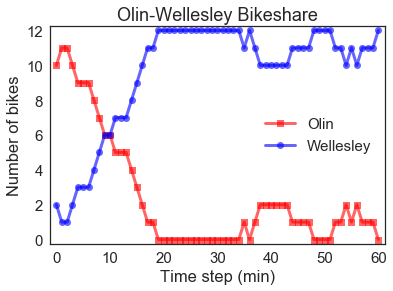

In [19]:
newfig()
plot_system(bikeshare)
decorate()
run_steps(bikeshare, 60, 0.4, 0.2)

After the simulation, we can print the number of unhappy customers at each location.

In [20]:
bikeshare.olin_empty

8

In [21]:
bikeshare.wellesley_empty

0

**Exercise:** Let's add a "clock" to keep track of how many time steps have elapsed:

1. Add a new system variable named `clock` to `bikeshare`, initialized to 0, and 

2. Modify `step` so it increments (adds one to) `clock` each time it is invoked.

Test your code by adding a print statement that prints the value of `clock` at the beginning of each time step.

In [22]:
# Here's a copy of step to get you started
bikeshare = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,clock=0,t_first_empty=None)

def step(system, p1=0.5, p2=0.5):
    """Simulate one minute of time.
    
    system: bikeshare System object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    print('clock = ', system.clock)
    system.clock += 1
    if flip(p1):
        bike_to_wellesley(system)
    
    if flip(p2):
        bike_to_olin(system)

clock =  0.0
clock =  1.0
clock =  2.0
clock =  3.0
clock =  4.0
clock =  5.0
clock =  6.0
clock =  7.0
clock =  8.0
clock =  9.0
clock =  10.0
clock =  11.0
clock =  12.0
clock =  13.0
clock =  14.0
clock =  15.0
clock =  16.0
clock =  17.0
clock =  18.0
clock =  19.0
clock =  20.0
clock =  21.0
clock =  22.0
clock =  23.0
clock =  24.0
clock =  25.0
clock =  26.0
clock =  27.0
clock =  28.0
clock =  29.0
clock =  30.0
clock =  31.0
clock =  32.0
clock =  33.0
clock =  34.0
clock =  35.0
clock =  36.0
clock =  37.0
clock =  38.0
clock =  39.0
clock =  40.0
clock =  41.0
clock =  42.0
clock =  43.0
clock =  44.0
clock =  45.0
clock =  46.0
clock =  47.0
clock =  48.0
clock =  49.0
clock =  50.0
clock =  51.0
clock =  52.0
clock =  53.0
clock =  54.0
clock =  55.0
clock =  56.0
clock =  57.0
clock =  58.0
clock =  59.0


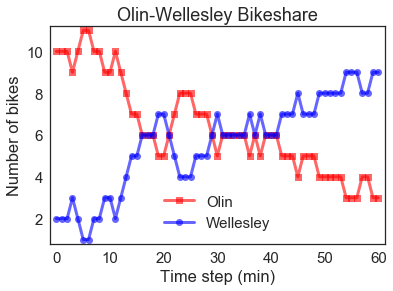

In [23]:
newfig()
plot_system(bikeshare)
decorate()
run_steps(bikeshare, 60, 0.4, 0.2)

In [24]:
# Solution goes here

After the simulation, check the final value of `clock`.

In [25]:
print(bikeshare.clock)

60.0


**Exercise:** Now suppose we'd like to know how long it takes to run out of bikes at either location.  Modify `move_bike` so the first time a student arrives at Olin and doesn't find a bike, it records the value of `clock` in a system variable.

Hint: create a system variable named `t_first_empty` and initialize it to -1, which is a special value (like `True` and `False`) that can be used to indicate a "special case".

Test your code by running a simulation for 60 minutes and checking the metrics.

In [26]:
example = None

if example == None:
    print('Yup, example is None.')

Yup, example is None.


In [27]:
bikeshare = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,clock=0,t_first_empty=-1)

In [28]:
def move_bike(system, n):
    olin_temp = system.olin - n
    if olin_temp < 0:
        system.olin_empty += 1
        if system.t_first_empty == -1:
            print('Setting t_first_empty')
            system.t_first_empty = system.clock
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        print('Hit Wellesley first')
        system.wellesley_empty += 1
        return
    
    system.olin = olin_temp
    system.wellesley = wellesley_temp

clock =  0
clock =  1
clock =  2
clock =  3
clock =  4
clock =  5
clock =  6
clock =  7
clock =  8
clock =  9
clock =  10
clock =  11
clock =  12
clock =  13
clock =  14
clock =  15
clock =  16
clock =  17
clock =  18
clock =  19
clock =  20
clock =  21
clock =  22
clock =  23
clock =  24
clock =  25
clock =  26
clock =  27
clock =  28
clock =  29
clock =  30
clock =  31
clock =  32
clock =  33
clock =  34
clock =  35
clock =  36
clock =  37
clock =  38
clock =  39
clock =  40
clock =  41
clock =  42
clock =  43
clock =  44
clock =  45
clock =  46
clock =  47
clock =  48
clock =  49
clock =  50
clock =  51
clock =  52
clock =  53
clock =  54
clock =  55
clock =  56
clock =  57
clock =  58
clock =  59


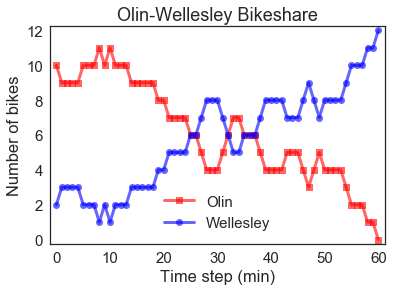

In [29]:
newfig()
plot_system(bikeshare)
decorate()
run_steps(bikeshare, 60, 0.4, 0.2)

After the simulation, check the final value of `t_first_empty`.

In [30]:
print(bikeshare.t_first_empty)

-1


Before we go on, let's put `step` and `move_bike` back the way we found them, so they don't break the examples below.

In [31]:
def step(system, p1=0.5, p2=0.5):
    if flip(p1):
        bike_to_wellesley(system)
    
    if flip(p2):
        bike_to_olin(system)

def move_bike(system, n):
    olin_temp = system.olin - n
    if olin_temp < 0:
        system.olin_empty += 1
        return
    
    wellesley_temp = system.wellesley + n
    if wellesley_temp < 0:
        system.wellesley_empty += 1
        return
    
    system.olin = olin_temp
    system.wellesley = wellesley_temp

## Returning values

Here's a simple function that returns a value:

In [32]:
def add_five(x):
    return x + 5

And here's how we call it.

In [33]:
y = add_five(3)
y

8

If you run a function on the last line of a cell, Jupyter displays the result:

In [34]:
add_five(5)

10

But that can be a bad habit, because usually if you call a function and don't assign the result in a variable, the result gets discarded.

In the following example, Jupyter shows the second result, but the first result just disappears.

In [35]:
add_five(3)
add_five(5)

10

When you call a function that returns a variable, it is generally a good idea to assign the result to a variable.

In [36]:
y1 = add_five(3)
y2 = add_five(5)

print(y1, y2)

8 10


**Exercise:** Write a function called `init_system` that creates a `System` object with the system variables `olin=10` and `wellesley=2`, and then returns the new `System` object.

Write a line of code that calls `init_system` and assigns the result to a variable.

In [37]:
def init_system():
    system = System(olin=10,wellesley=2)
    return system   

In [38]:
newSystem = init_system()
newSystem

,value
olin,10
wellesley,2


## Running simulations

Before we go on, I want to update `run_steps` so it doesn't always plot the results.  The new version takes an additional parameter, `plot_flag`, to indicate whether we want to plot.

"flag" is a conventional name for a boolean variable that indicates whether or not a condition is true.

This version of `run_steps` works even if `num_steps` is not an integer.  It uses the `int` function to round down.  See https://docs.python.org/3/library/functions.html#int

In [39]:
def run_steps(system, num_steps=1, p1=0.5, p2=0.5, plot_flag=True):
    """Simulate the given number of time steps.
    
    `num_steps` should be an integer; if not, it gets rounded down.
    
    system: bikeshare System object
    num_steps: number of time steps
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    plot_flag: boolean, whether to plot
    """
    for i in range(int(num_steps)):
        step(system, p1, p2)
        if plot_flag:
            plot_system(system)

Now when we run a simulation, we can choose not to plot the results:

In [40]:
bikeshare = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
run_steps(bikeshare, 60, 0.4, 0.2, plot_flag=False)

But after the simulation, we can still read the metrics.

In [41]:
bikeshare.olin_empty

0

Let's wrap all that in a function.

In [42]:
def run_simulation():
    system = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(system, 60, 0.4, 0.2, plot_flag=False)
    return system

And test it.

In [43]:
system = run_simulation()

In [44]:
print(system.olin_empty, system.wellesley_empty)

1 0


If we generalize `run_simulation` to take `p1` and `p2`, we can use it to run simulations with a range of values for the parameters.

In [45]:
def run_simulation(p1=0.4, p2=0.2):
    bikeshare = System(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)
    run_steps(bikeshare, 60, p1, p2, plot_flag=False)
    return bikeshare

When `p1` is small, we probably don't run out of bikes at Olin.

In [46]:
system = run_simulation(p1=0.2)
system.olin_empty

0

When `p1` is large, we probably do.

In [47]:
system = run_simulation(p1=0.6)
system.olin_empty

13

**Exercise:**  Write a version of `run_simulation` that takes all five model parameters as function parameters.

In [48]:
def run_simulation(olin=10, wellesley=10, p1=.4, p2=.2, num_steps=60):
    bikeshare = System(olin = olin, wellesley = wellesley, olin_empty = 0, wellesley_empty = 0)
    run_steps(bikeshare, 60, p1, p2, plot_flag=False)
    return bikeshare


In [49]:
# Solution goes here

## More for loops

`linspace` creates a NumPy array of equally spaced numbers.

In [50]:
p1_array = linspace(start=0, stop=1, num=5)
p1_array

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ])

We can use an array in a `for` loop, like this:

In [51]:
for p1 in p1_array:
    print(p1)

0.0
0.25
0.5
0.75
1.0


This will come in handy in the next section.

**Exercise:** The function `linspace` is part of NumPy.  [You can read the documentation here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html).

Use `linspace` to make an array of 10 equally spaced numbers from 1 to 10 (including both).

In [52]:
p1_array = linspace(start=1, stop=10, num=11)
for p1 in p1_array:
    print(p1)

1.0
1.9
2.8
3.7
4.6
5.5
6.4
7.3
8.2
9.1
10.0


**Exercise:** The `modsim` library provides a related function called `linrange`.  You can view the documentation by running the following cell:

In [53]:
help(linrange)

Help on function linrange in module modsim:

linrange(start=0, stop=None, step=1, **kwargs)
    Returns an array of evenly-spaced values in the interval [start, stop].
    
    This function works best if the space between start and stop
    is divisible by step; otherwise the results might be surprising.
    
    By default, the last value in the array is `stop` (at least approximately).
    If you provide the keyword argument `endpoint=False`, the last value
    in the array is `stop-step`. 
    
    start: first value
    stop: last value
    step: space between values
    
    Also accepts the same keyword arguments as np.linspace.  See
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html
    
    returns: array or Quantity



Use `linrange` to make an array of numbers from 1 to 10 with a step size of 2.

In [54]:
p1_array = linrange(start = 1, stop = 11, step=2)
for p1 in p1_array:
    print(p1)

1.0
3.0
5.0
7.0
9.0
11.0


## Sweeping parameters

The following example runs simulations with a range of values for `p1`; after each simulation, it prints the number of unhappy customers at the Olin station:

In [55]:
p1_array = linspace(0, 1, 11)
p1_array

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [56]:
for p1 in p1_array:
    system = run_simulation(p1=p1)
    print(p1, system.olin_empty)

0.0 0
0.1 0
0.2 0
0.3 0
0.4 5
0.5 5
0.6 14
0.7 16
0.8 32
0.9 32
1.0 42


Now we can do the same thing, but plotting the results instead of printing them.



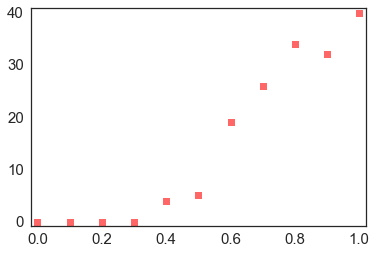

In [57]:
newfig()
for p1 in p1_array:
    system = run_simulation(p1=p1)
    plot(p1, system.olin_empty, 'rs', label='olin')

As always, we should decorate the figure.  This version of `decorate` takes `xlabel` as a parameter, for reasons you will see soon.

In [58]:
def decorate(xlabel):
    legend(loc='best')
    label_axes(title='Olin-Wellesley Bikeshare',
               xlabel=xlabel, 
               ylabel='Number of unhappy customers')

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


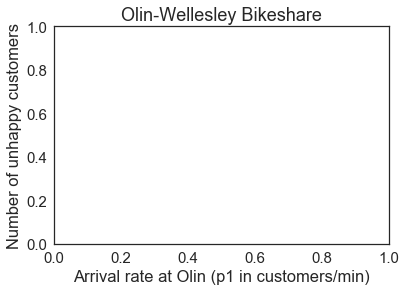

In [59]:
decorate(xlabel='Arrival rate at Olin (p1 in customers/min)')

**Exercise:** Wrap this code in a function named `parameter_sweep` that takes an array called `p1_array` as a parameter.  It should create a new figure, run a simulation for each value of `p1` in `p1_array`, and plot the results.

Once you have the function working, modify it so it also plots the number of unhappy customers at Wellesley.  Looking at the plot, can you estimate a range of values for `p1` that minimizes the total number of unhappy customers?

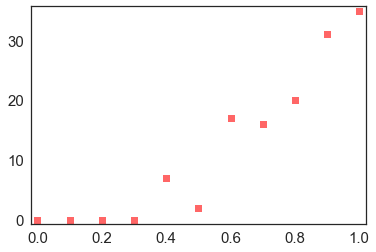

In [60]:
def parameter_sweep(p1_array):
    newfig()
    for p1 in p1_array:
        system = run_simulation(p1=p1)
        plot(p1, system.olin_empty, 'rs', label='olin')

parameter_sweep(p1_array)        
    

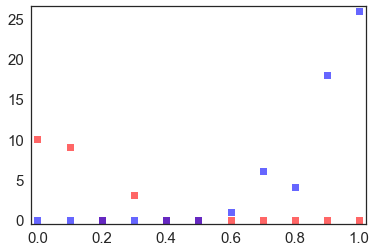

In [61]:
def parameter_sweep(p1_array):
    newfig()
    for p1 in p1_array:
        system = run_simulation(p1=p1)
        system = run_simulation(p2=p1)
        plot(p1, system.olin_empty, 'rs', label='olin')
        plot(p1, system.wellesley_empty, 'bs', label='wellesley')

parameter_sweep(p1_array)

**Exercise:** Write a function called `parameter_sweep2` that runs simulations with `p1=0.2` and a range of values for `p2`.

Note: If you run `parameter_sweep2` a few times without calling `newfig`, you can plot multiple runs on the same axes, which will give you a sense of how much random variation there is from one run to the next. 

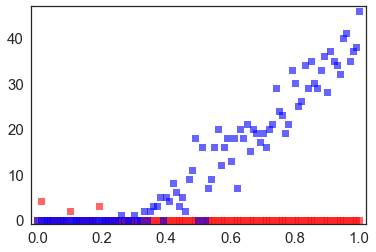

In [62]:
p2_array = linspace(0,1,101)
def parameter_sweep2(p2_array):
    newfig()
    for p2 in p2_array:
        system = run_simulation(p1=.2, p2=p2)
        plot(p2, system.olin_empty, 'rs', label='olin')
        plot(p2, system.wellesley_empty, 'bs', label='wellesley')

parameter_sweep2(p2_array)    

In [63]:
# Solution goes here

In [64]:
# Solution goes here

**Exercise:** Hold `p1=0.4` and `p2=0.2`, and sweep a range of values for `num_steps`.

Hint: You will need a version of `run_simulation` that takes `num_steps` as a parameter.

Hint: Because `num_steps` is supposed to be an integer use `range` rather than `linrange`.

In [65]:
def run_simulation(olin=10, wellesley=10, p1=.4, p2=.2, num_steps=60):
    bikeshare = System(olin = olin, wellesley = wellesley, olin_empty = 0, wellesley_empty = 0)
    run_steps(bikeshare, 60, p1, p2, plot_flag=False)
    return bikeshare

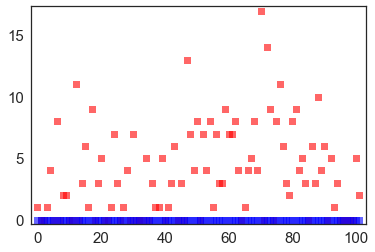

In [66]:
num_steps_array = linrange(0,101)
def num_steps_sweep(num_steps_array):
    newfig()
    for num_steps in num_steps_array:
        system = run_simulation(num_steps = num_steps)
        plot(num_steps, system.olin_empty, 'rs', label='olin')
        plot(num_steps, system.wellesley_empty, 'bs', label='wellesley')

num_steps_sweep(num_steps_array)    

**Exercise:** The code below runs a simulation with the same parameters 10 times and computes the average number of unhappy customers.

1.  Wrap this code in a function called `run_simulations` that takes `num_runs` as a parameter.

2.  Test `run_simulations`, and increase `num_runs` until the results are reasonably consistent from one run to the next.

3.  Generalize `run_simulations` so it also takes the initial value of `olin` as a parameter.

4.  Run the generalized version with `olin=12`.  How much do the two extra bikes decrease the average number of unhappy customers.

5.  Make a plot that shows the average number of unhappy customers as a function of the initial number of bikes at Olin.

In [67]:
num_runs = 20
unhappy = 0

for i in range(num_runs):
    system = run_simulation(p1=0.4, p2=0.2, olin=10, wellesley=2, num_steps=60)
    unhappy += system.olin_empty + system.wellesley_empty
unhappy / num_runs

4.4500000000000002

In [68]:
def run_simulations(olin, num_runs=1000):
    unhappy = 0
    for i in range(num_runs):
        system = run_simulation(p1=0.4, p2=0.2, olin=olin, wellesley=2, num_steps=60)
        unhappy += system.olin_empty + system.wellesley_empty
    return unhappy / num_runs

run_simulations(olin = 12, num_runs = 20)

3.2000000000000002

In [69]:
run_simulations(olin = 10)

3.5880000000000001

In [70]:
run_simulations(olin=12)

2.3759999999999999

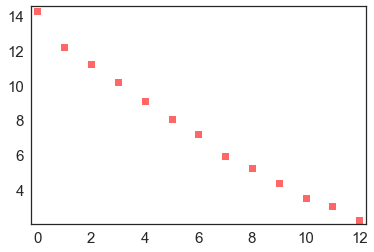

In [71]:
newfig()
for olin in range(0,13,1):
    avg = run_simulations(olin = olin)
    plot(olin, avg, 'rs')

In [72]:
# Solution goes here